# 1
скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
!unzip archive.zip

Archive:  archive.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import pandas as pd
data = pd.read_csv('data.csv')

In [2]:
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


# 2

поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
data.rename(columns={'conversion':'target', 'offer': 'treatment'}, inplace = True)

In [4]:
data.loc[(data.treatment == 'No Offer'), 'treatment'] = 0
data.loc[(data.treatment == 'Buy One Get One'), 'treatment'] = 1
data.loc[(data.treatment == 'Discount'), 'treatment'] = 1

# 3
сделать разбиение набора данных не тренировочную и тестовую выборки

In [5]:
X = data.drop('target', axis = 1)
y = data['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
treat_train = X_train['treatment']
treat_test = X_test['treatment']
X_train = X_train.drop('treatment', axis = 1)
X_test = X_test.drop('treatment', axis = 1)

# 4
сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]
    
O_coder = Pipeline([
     ('Selector', ColumnSelector(['zip_code','channel'])), 
     ('OHEEncoder', OHEEncoder(['zip_code','channel']))])

recency =  Pipeline([
                ('selector', NumberSelector(key='recency')),
                ('standard', StandardScaler())
            ])

history =  Pipeline([
                ('selector', NumberSelector(key='history')),
                ('standard', StandardScaler())
            ])


number_features = Pipeline([
                ('selector', ColumnSelector(key=['used_discount',
                                                 'used_bogo', 'is_referral']))
            ])
feats = FeatureUnion([('O_coder', O_coder),
                      ('recency', recency),
                      ('continuos_features', number_features),
                      ('history', history)])
feature_processing = Pipeline([('feats', feats)])

In [7]:
X_train = feature_processing.fit_transform(X_train, y = None)
X_test = feature_processing.fit_transform(X_test, y = None)

# 5
провести uplift-моделирование 3 способами:
одна модель с признаком коммуникации (S-learner)
модель с трансформацией таргета
вариант с двумя независимыми моделями

## одна модель

In [20]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [25]:
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

## Трансформация классов

In [26]:
from sklift.models import ClassTransformation

ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

## 2. Две независимые модели

In [28]:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

Solo Model


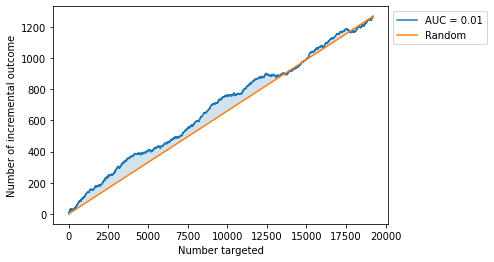

ClassTransform Model


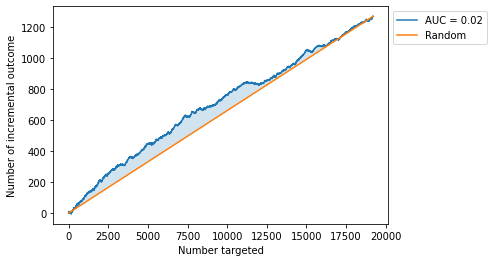

Two Model


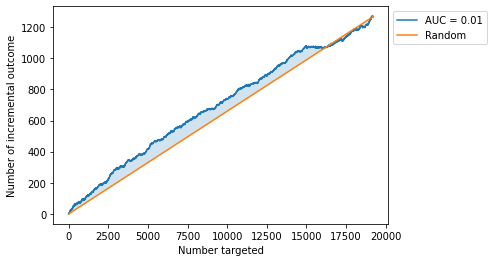

In [29]:
import matplotlib.pyplot as plt
from sklift.viz import plot_uplift_curve

print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

# 6
в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [34]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
models_results['approach'].append('ClassTransform Model')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.096245,0.093130
1,ClassTransform Model,0.106579,0.092885
2,TwoModels,0.096279,0.088863
